## Connect with Google Drive

In [0]:
from google.colab import drive 
drive.mount("/betogaona7")

Drive already mounted at /betogaona7; to attempt to forcibly remount, call drive.mount("/betogaona7", force_remount=True).


In [0]:
%cd ./../betogaona7/My Drive/app/Recognition

/betogaona7/My Drive/app/Recognition


In [0]:
%pwd

## Imports 

In [0]:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
from torch import optim

## Build dataset

In [0]:
def imgs_with_id(src):
  data = []
  imgs = 0
  for path, subdir, files in os.walk(src):
    for file in files:
      if path[7:10] == "P2L":
        if file[-3:] == "pgm":
          data.append((os.path.join(path, file), path[-4:]))
          imgs += 1
  return data, imgs 

data, total = imgs_with_id("datacp/")
#data, total = imgs_with_id("./data")
print("Example: img ", data[0][0], " subject id ", data[0][1], " total imgs ", total)

Example: img  datacp/P2L_S1_C1/0005/00004614.pgm  subject id  0005  total imgs  17696


In [0]:
class ChokePoint(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.transform = transform
  
  def __getitem__(self, index):
    record1 = random.choice(self.data)
    same_class = random.randint(0,1)
    if same_class:
      while True:
        record2 = random.choice(self.data)
        if record1[1] == record2[1]:
          label = 1
          break
    else:
      while True:
        record2 = random.choice(self.data)
        if record1[1] != record2[1]:
          label = 0
          break
    
    img1 = Image.open(record1[0])
    img2 = Image.open(record2[0])
    
    # Convert to grayscale 
    img1 = img1.convert("L")
    img2 = img2.convert("L")   
    
    # Convert to tensor
    label = torch.from_numpy(np.array([label], dtype=np.float32))
    
    if self.transform is not None:
      img1 = self.transform(img1)
      img2 = self.transform(img2)
    
    return img1, img2, label
  
  def __len__(self):
    return len(self.data)

In [0]:
dataset = ChokePoint(data, transform=transforms.Compose([transforms.Resize((105,105)),
                                                         transforms.RandomHorizontalFlip(0.5),
                                                         transforms.ToTensor()]))

trainloader = torch.utils.data.DataLoader(dataset, shuffle=True, num_workers=8, batch_size=64)

In [0]:
batch_example = next(iter(trainloader))
print("img1 ", batch_example[0].shape, " img2 ", batch_example[1].shape, " label", batch_example[2].shape)

img1  torch.Size([64, 1, 105, 105])  img2  torch.Size([64, 1, 105, 105])  label torch.Size([64, 1])


Label:  tensor([0.])


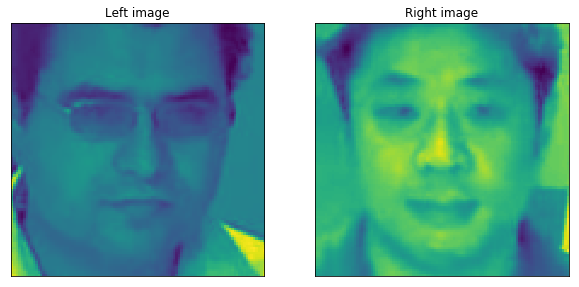

In [0]:
def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None

n_batch = 5

print("Label: ", batch_example[2][n_batch])
plot_imgs([batch_example[0][n_batch].reshape(105, 105), 
          batch_example[1][n_batch].reshape(105, 105)], ["Left image", "Right image"])


## Build model

In [0]:
class siameseCNN(nn.Module):
  def __init__(self):
    super().__init__()        
    """
    
    self.CNN = nn.Sequential(nn.Conv2d(1, 64, 10), #105 
                             nn.ReLU(inplace=True),
                             nn.MaxPool2d(2,2), #52
                             
                             nn.Conv2d(64, 128, 7),
                             nn.ReLU(inplace=True),
                             nn.MaxPool2d(2,2), #26
                             
                             nn.Conv2d(128, 128, 4),
                             nn.ReLU(inplace=True),
                             nn.MaxPool2d(2,2), #13
                             
                             nn.Conv2d(128, 256, 4),
                             nn.ReLU(inplace=True))
    
    self.FC =  nn.Sequential(nn.Linear(9216, 128),
                             nn.Sigmoid(),
                             
                             nn.Linear(128, 1)) """
    
    self.CNN = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8))
    
    self.FC = nn.Sequential(
            nn.Linear(8*105*105, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 1))
    
                            
  
  def forward_img(self, x):
    x = self.CNN(x)
    x = x.view(x.size()[0], -1)
    x = self.FC(x)
    
    return x
    
  def forward(self, x1, x2):
    x1 = self.forward_img(x1)
    x2 = self.forward_img(x2)
    return x1, x2

## Define loss 

In [0]:
def constrastiveLoss(x1, x2, label):
  euclidean_distance = F.pairwise_distance(x1, x2, keepdim=True)
  loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + 
                      (label) * torch.pow(torch.clamp(2.- euclidean_distance, min=0), 2))
  return loss

## Train network

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training in", device)

model = siameseCNN()
model.to(device)

optimizer = optim.RMSprop(model.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

Training in cuda:0


In [0]:
epochs = 50
print_every = 10

counter = []
history = []
iteration = 0
best = 0

for epoch in range(epochs):
  for i, batch in enumerate(trainloader, 0):
    x1, x2, label = batch
    x1, x2, label = x1.to(device), x2.to(device), label.to(device)
    optimizer.zero_grad()
    
    out1, out2 = model.forward(x1, x2)
    loss = constrastiveLoss(out1, out2, label)
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      print("Epoch: {} loss: {}".format(epoch+1, loss.item()))
      iteration += print_every
      counter.append(iteration)
      history.append(loss.item())
      if best < loss.item():
        torch.save(model.state_dict(), "./siamese-pytorch.pth")
        best = loss.item()

Epoch: 1 loss: 1.413050651550293
Epoch: 1 loss: 1.5534751415252686
Epoch: 1 loss: 1.263443112373352
Epoch: 1 loss: 1.3843348026275635
Epoch: 1 loss: 1.3501938581466675
Epoch: 1 loss: 1.5960501432418823
Epoch: 1 loss: 1.4501631259918213
Epoch: 1 loss: 1.3744815587997437
Epoch: 1 loss: 1.3611005544662476
Epoch: 1 loss: 1.2593941688537598
Epoch: 1 loss: 1.5960986614227295
Epoch: 1 loss: 1.4134411811828613
Epoch: 1 loss: 1.4864845275878906
Epoch: 1 loss: 1.5305652618408203
Epoch: 1 loss: 1.2538529634475708
Epoch: 1 loss: 1.299262285232544
Epoch: 1 loss: 1.4954116344451904
Epoch: 1 loss: 1.4747815132141113
Epoch: 1 loss: 1.507157325744629
Epoch: 1 loss: 1.352624535560608
Epoch: 1 loss: 1.4227430820465088
Epoch: 1 loss: 1.4231960773468018
Epoch: 1 loss: 1.1914749145507812
Epoch: 1 loss: 1.687276840209961
Epoch: 1 loss: 1.312038540840149
Epoch: 1 loss: 1.4218769073486328
Epoch: 1 loss: 1.6537061929702759
Epoch: 1 loss: 1.6547069549560547
Epoch: 2 loss: 1.5167083740234375
Epoch: 2 loss: 1.3397

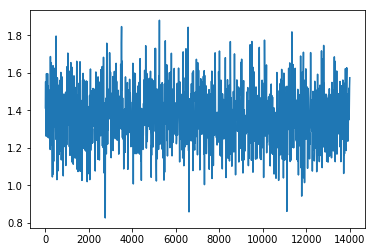

In [0]:
plt.plot(counter, history)
plt.show()

In [0]:
model.eval()

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() 

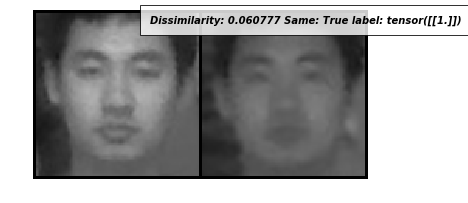

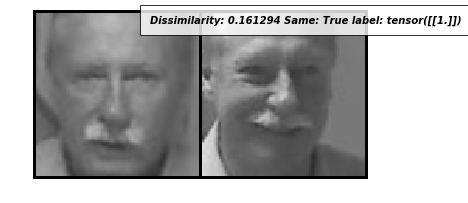

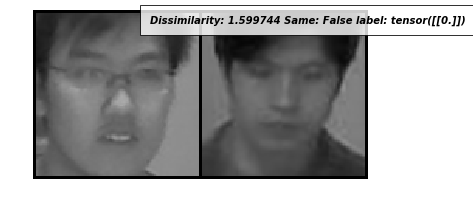

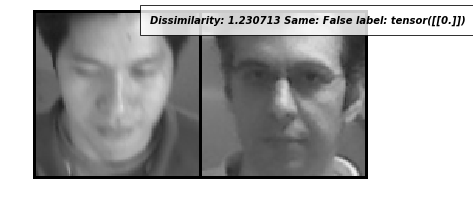

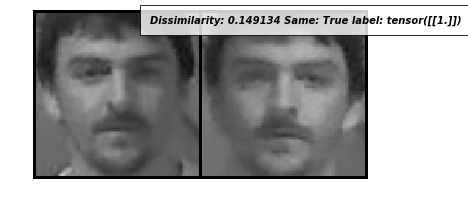

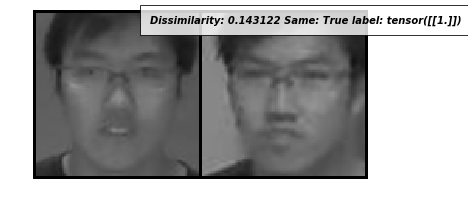

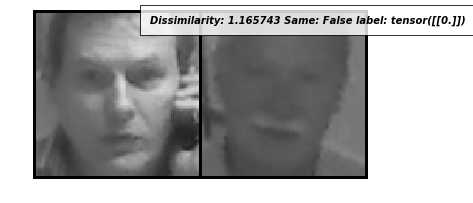

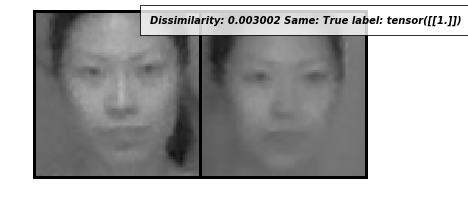

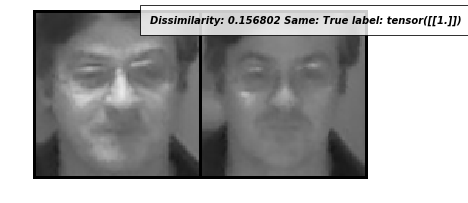

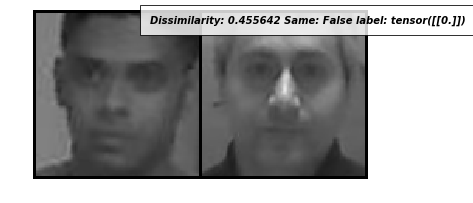

In [0]:

dataset = ChokePoint(data, transform=transforms.Compose([transforms.Resize((105, 105)),
                                                         transforms.ToTensor()]))
                     
testloader = torch.utils.data.DataLoader(dataset, shuffle=True, num_workers=8, batch_size=1)

it = iter(testloader)
x1, _, _ = next(it)

for i in range(10):
  x1, x2, label = next(it)
  concatenated = torch.cat((x1, x2), 0)
                     
  out1, out2 = model(x1.to(device), x2.to(device))
  euc_dst = F.pairwise_distance(out1, out2)
  
  same = False
  if euc_dst < 0.4:
    same = True
    
  imshow(torchvision.utils.make_grid(concatenated), "Dissimilarity: {:2f} Same: {} label: {}". format(euc_dst.item(), same, label))
